# Pre-processing of GLAMOS MB data:

## Setting up:

In [18]:
import pandas as pd
import os
import warnings
from tqdm.notebook import tqdm
import re
import massbalancemachine as mbm
import geopandas as gpd
from shapely.geometry import Polygon, LineString, Point
from scipy.spatial.distance import cdist
import pyproj
import matplotlib.pyplot as plt
from scripts.helpers import *
from scripts.glamos_preprocess import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Transform .dat files to .csv:

In [2]:
# Get all files with pmb (for winter and annual mb):
glamosfiles_mb_a, glamosfiles_mb_w = [], []
for file in os.listdir(path_PMB_GLAMOS_a_raw):
    # check if current path is a file
    if os.path.isfile(os.path.join(path_PMB_GLAMOS_a_raw, file)):
        glamosfiles_mb_a.append(file)

for file in os.listdir(path_PMB_GLAMOS_w_raw):
    # check if current path is a file
    if os.path.isfile(os.path.join(path_PMB_GLAMOS_w_raw, file)):
        glamosfiles_mb_w.append(file)

print('Examples of index stake raw files:\n', glamosfiles_mb_a[:5])

# Transform all files to csv
RUN = True
if RUN:
    emptyfolder(path_PMB_GLAMOS_csv_a)
    emptyfolder(path_PMB_GLAMOS_csv_w)
    for file in glamosfiles_mb_a:
        fileName = re.split('.dat', file)[0]
        processDatFile(fileName, path_PMB_GLAMOS_a_raw, path_PMB_GLAMOS_csv_a)

    for file in glamosfiles_mb_w:
        fileName = re.split('.dat', file)[0]
        processDatFile(fileName, path_PMB_GLAMOS_w_raw, path_PMB_GLAMOS_csv_w)

    # Separate clariden into clariden II and III
    fileName = 'clariden_annual.csv'
    clariden_csv_a = pd.read_csv(path_PMB_GLAMOS_csv_a + fileName,
                                 sep=',',
                                 header=0,
                                 encoding='latin-1')
    clariden_csv_a[clariden_csv_a['# name'] == 'L'].to_csv(
        path_PMB_GLAMOS_csv_a + 'claridenL_annual.csv', index=False)
    clariden_csv_a[clariden_csv_a['# name'] == 'U'].to_csv(
        path_PMB_GLAMOS_csv_a + 'claridenU_annual.csv', index=False)

    fileName = 'clariden_winter.csv'
    clariden_csv_w = pd.read_csv(path_PMB_GLAMOS_csv_w + fileName,
                                 sep=',',
                                 header=0,
                                 encoding='latin-1')
    clariden_csv_w[clariden_csv_w['# name'] == 'L'].to_csv(
        path_PMB_GLAMOS_csv_w + 'claridenL_winter.csv', index=False)
    clariden_csv_w[clariden_csv_w['# name'] == 'U'].to_csv(
        path_PMB_GLAMOS_csv_w + 'claridenU_winter.csv', index=False)

    os.remove(path_PMB_GLAMOS_csv_a + 'clariden_annual.csv')
    os.remove(path_PMB_GLAMOS_csv_w + 'clariden_winter.csv')

# Example:
fileName = 'aletsch_annual.csv'
aletsch_csv = pd.read_csv(path_PMB_GLAMOS_csv_a + fileName,
                          sep=',',
                          header=0,
                          encoding='latin-1')
aletsch_csv.head(2)

Examples of index stake raw files:
 ['tortin_annual.dat', 'forno_annual.dat', 'rosatsch_annual.dat', 'petitplanneve_annual.dat', 'corvatsch_annual.dat']


,# name,date0,time0,date1,time1,period,date_quality,x_pos,y_pos,z_pos,...,density,density_quality,mb_we,measurement_quality,measurement_type,mb_error,reading_error,density_error,error_evaluation_method,source
0,NMF,19120909,1200,19130920,1200,376.0,0,647166.0,150081.0,2850.0,...,700,4,-1120,2,6,1094,1085,134,0,glrep
1,NMG1,19120924,1200,19130920,1200,361.0,0,647089.0,150780.0,2802.0,...,539,6,592,4,6,873,870,71,0,glrep


##  Measurement periods:
### Annual measurements: 
Process annual measurements and put all stakes into one csv file

In [3]:
# Assemble all into one csv file:
RUN = True
if RUN:
    # Annual:
    df_annual_raw = pd.DataFrame()
    for file in tqdm(os.listdir(path_PMB_GLAMOS_csv_a), desc='Annual stakes'):
        fileName = re.split('.csv', file)[0]
        glacierName = re.split('_', fileName)[0]
        df = pd.read_csv(path_PMB_GLAMOS_csv_a + file,
                         sep=',',
                         header=0,
                         encoding='latin-1')
        df['glacier'] = glacierName
        df['period'] = 'annual'

        # Correct years and add hydrol. year:
        df_processed = transformDates(df)

        # Remove obvious duplicates:
        df_processed = df_processed.drop_duplicates()

        # Transform to lat/lon system
        df_processed = LV03toWGS84(df_processed)

        df_annual_raw = pd.concat([df_annual_raw, df_processed])

    # Get the year:
    df_annual_raw['YEAR'] = df_annual_raw['date1'].apply(
        lambda x: pd.to_datetime(x).year)

    # download all stakes coordinates:
    df_annual_raw[['glacier', '# name', 'lat', 'lon', 'period'
                   ]].to_csv(path_PMB_GLAMOS_csv + 'coordinates_annual.csv')

    # Save all stakes:
    df_annual_raw.to_csv(path_PMB_GLAMOS_csv + 'point_annual.csv')

df_annual_raw = pd.read_csv(path_PMB_GLAMOS_csv + 'point_annual.csv',
                            sep=',',
                            header=0,
                            encoding='latin-1').drop(columns='Unnamed: 0')

# Reshape to WGMS format:
# re-order columns:
df_annual_raw = df_annual_raw[[
    'YEAR', '# name', 'glacier', 'date0', 'date1', 'lat', 'lon', 'height',
    'mb_we', 'period', 'date_fix0', 'date_fix1', 'time0', 'time1',
    'date_quality', 'position_quality', 'mb_raw', 'density', 'density_quality',
    'measurement_quality', 'measurement_type', 'mb_error', 'reading_error',
    'density_error', 'error_evaluation_method', 'source'
]]
df_annual_raw.rename(columns={
    '# name': 'POINT_ID',
    'lat': 'POINT_LAT',
    'lon': 'POINT_LON',
    'height': 'POINT_ELEVATION',
    'date0': 'FROM_DATE',
    'date1': 'TO_DATE',
    'mb_we': 'POINT_BALANCE',
    'glacier': 'GLACIER',
    'period': 'PERIOD'
},
                     inplace=True)
# remove duplicates:
df_annual_raw = df_annual_raw.drop_duplicates()
df_annual_raw.head(2)

Annual stakes:   0%|          | 0/57 [00:00<?, ?it/s]

,YEAR,POINT_ID,GLACIER,FROM_DATE,TO_DATE,POINT_LAT,POINT_LON,POINT_ELEVATION,POINT_BALANCE,PERIOD,...,mb_raw,density,density_quality,measurement_quality,measurement_type,mb_error,reading_error,density_error,error_evaluation_method,source
0,2003,01,oberaar,2002-10-06,2003-10-11,46.538806,8.233237,2389.812633,-6174,annual,...,-686,900,1,1,1,102,45,92,0,hm
1,2003,02,oberaar,2002-10-06,2003-10-11,46.536611,8.225514,2499.825727,-5310,annual,...,-590,900,1,1,1,91,45,79,0,hm


### Winter measurements:
For each point in annual meas., take winter meas that was taken closest:

In [4]:
winter_glaciers = [
    re.split('_winter.csv', f)[0] for f in os.listdir(path_PMB_GLAMOS_csv_w)
]
RUN = False
if RUN:
    emptyfolder(path_PMB_GLAMOS_csv_w_clean)
    for glacier in tqdm(df_annual_raw.GLACIER.unique(),
                        desc='Glaciers',
                        leave=False,
                        position=0):
        # If glacier does not have winter measurements:
        if glacier not in winter_glaciers:
            continue

        # Get winter all PMB measurements (a lot more than annual)
        df_winter = pd.read_csv(path_PMB_GLAMOS_csv_w + glacier +
                                '_winter.csv',
                                sep=',',
                                header=0,
                                encoding='latin-1')
        df_winter['period'] = 'winter'
        df_winter['glacier'] = glacier

        # Correct years and add hydrol. year:
        df_winter = transformDates(df_winter)

        # Remove obvious duplicates:
        df_winter = df_winter.drop_duplicates()

        # Transform to lat/lon system
        df_winter = LV03toWGS84(df_winter)

        # Add the year:
        df_winter['YEAR'] = df_winter['date1'].apply(
            lambda x: pd.to_datetime(x).year)

        # Reshape to WGMS format:
        df_winter.rename(columns={
            '# name': 'POINT_ID',
            'lat': 'POINT_LAT',
            'lon': 'POINT_LON',
            'height': 'POINT_ELEVATION',
            'date0': 'FROM_DATE',
            'date1': 'TO_DATE',
            'mb_we': 'POINT_BALANCE',
            'glacier': 'GLACIER',
            'period': 'PERIOD'
        },
                         inplace=True)
        # re-order columns:
        df_winter = df_winter[[
            'YEAR', 'POINT_ID', 'GLACIER', 'FROM_DATE', 'TO_DATE', 'POINT_LAT',
            'POINT_LON', 'POINT_ELEVATION', 'POINT_BALANCE', 'PERIOD',
            'date_fix0', 'date_fix1', 'time0', 'time1', 'date_quality',
            'position_quality', 'mb_raw', 'density', 'density_quality',
            'measurement_quality', 'measurement_type', 'mb_error',
            'reading_error', 'density_error', 'error_evaluation_method',
            'source'
        ]]

        winter_indices = []
        # Iterate over all rows in annual stakes:
        for index in tqdm(range(
                len(df_annual_raw[df_annual_raw.GLACIER == glacier])),
                          desc='rows',
                          leave=False,
                          position=1):
            pointA = df_annual_raw[df_annual_raw.GLACIER ==
                                   glacier].iloc[index]
            yearA = pointA.YEAR

            # Filter winter to same year as point:
            df_winter_year = df_winter[df_winter.YEAR == yearA]

            # If no winter measurement was taken that year:
            if len(df_winter_year) == 0:
                continue

            # Calculate closest winter point to annual stake:
            df_winter_year['point'] = [(x, y) for x, y in zip(
                df_winter_year['POINT_LAT'], df_winter_year['POINT_LON'])]
            pointA['point'] = (pointA.POINT_LAT, pointA.POINT_LON)
            closest = closest_point(pointA['point'],
                                    list(df_winter_year['point']))

            # Convert to LAEA Europe
            x_laea, y_laea = latlon_to_laea(closest[0], closest[1])
            x_laea_point, y_laea_point = latlon_to_laea(
                pointA.POINT_LAT, pointA.POINT_LON)

            # Calculate distance:
            distance_m = np.sqrt((x_laea_point - x_laea)**2 +
                                 (y_laea_point - y_laea)**2)

            # Only keep winter stakes that are within 10m:
            if distance_m > 10:
                continue
            else:
                winter_indices.append(df_winter_year[df_winter_year['point'] ==
                                                     closest].index[0])

        # Save winter stake:
        df_winter_stakes = df_winter.iloc[winter_indices]
        df_winter_stakes.to_csv(path_PMB_GLAMOS_csv_w_clean + glacier +
                                '_winter.csv')

### Assemble both periods:

In [5]:
df_all_raw = df_annual_raw.copy()
for file in os.listdir(path_PMB_GLAMOS_csv_w_clean):
    fileName = re.split('.csv', file)[0]
    glacierName = re.split('_', fileName)[0]
    df_winter = pd.read_csv(path_PMB_GLAMOS_csv_w_clean + file,
                            sep=',',
                            header=0,
                            encoding='latin-1').drop(columns='Unnamed: 0')

    df_all_raw = pd.concat([df_all_raw, df_winter])

print('Number of winter and annual samples:', len(df_all_raw))
print('Number of winter samples:',
      len(df_all_raw[df_all_raw.PERIOD == 'winter']))
print('Number of annual samples:',
      len(df_all_raw[df_all_raw.PERIOD == 'annual']))

# download all stakes coordinates:
df_all_raw[['GLACIER', 'POINT_ID', 'POINT_LAT', 'POINT_LON',
            'PERIOD']].to_csv(path_PMB_GLAMOS_csv + 'coordinates_all.csv')

# Save all stakes:
df_all_raw.to_csv(path_PMB_GLAMOS_csv + 'point_all.csv')

df_all_raw = pd.read_csv(path_PMB_GLAMOS_csv + 'point_all.csv',
                         sep=',',
                         header=0,
                         encoding='latin-1').drop(columns='Unnamed: 0')

Number of winter and annual samples: 13038
Number of winter samples: 2350
Number of annual samples: 10688


## Add RGIs:

In [6]:
# RGI Ids:
# Read rgi ids:
path_rgi = '../../../data/GLAMOS/CH_glacier_ids_long.csv'
rgi_df = pd.read_csv(path_rgi, sep=',')
rgi_df.rename(columns=lambda x: x.strip(), inplace=True)
rgi_df.sort_values(by='short_name', inplace=True)
rgi_df.set_index('short_name', inplace=True)
rgi_df.head(2)

,full_name,sgi-id,rgi_id.v6,rgi_id.v7,Issue
short_name,,,,,
adler,Adler,B56/03,RGI60-11.02764,RGI2000-v7.0-G-11-01075,False
albigna,Albigna,NaN,RGI60-11.02285,RGI2000-v7.0-G-11-02309,True


In [7]:
# Keep important features:
df_pmb = df_all_raw[[
    'YEAR',
    'POINT_ID',
    'GLACIER',
    'FROM_DATE',
    'TO_DATE',
    'POINT_LAT',
    'POINT_LON',
    'POINT_ELEVATION',
    'POINT_BALANCE',
    'PERIOD',
]]
df_pmb.head(3)

,YEAR,POINT_ID,GLACIER,FROM_DATE,TO_DATE,POINT_LAT,POINT_LON,POINT_ELEVATION,POINT_BALANCE,PERIOD
0,2003,01,oberaar,2002-10-06,2003-10-11,46.538806,8.233237,2389.812633,-6174,annual
1,2003,02,oberaar,2002-10-06,2003-10-11,46.536611,8.225514,2499.825727,-5310,annual
2,2003,03,oberaar,2002-10-06,2003-10-11,46.532136,8.207734,2679.854419,-4320,annual


In [8]:
# Add RGIs:
# Specify the shape filename of the glaciers outline obtained from RGIv6
glacier_outline_fname = '../../../data/GLAMOS/nsidc0770_11.rgi60.CentralEurope/11_rgi60_CentralEurope.shp'

# Load the target data and the glacier outlines
glacier_outline = gpd.read_file(glacier_outline_fname)

# Add RGI IDs through intersection with shapefiles:
df_pmb = mbm.utils.get_rgi(data=df_pmb, glacier_outlines=glacier_outline)

# Add RGIs without intersections (by finding the closest polygon):
# for points where polygon intersection is NaN (about a 1000)
no_match_df = df_pmb[df_pmb.RGIId.isna()]
geometry = [
    Point(lon, lat)
    for lon, lat in zip(no_match_df["POINT_LON"], no_match_df["POINT_LAT"])
]
points_gdf = gpd.GeoDataFrame(no_match_df,
                              geometry=geometry,
                              crs=glacier_outline.crs)
for index in tqdm(no_match_df.index):
    point = points_gdf.loc[index]['geometry']
    polygon_index = glacier_outline.distance(point).sort_values().index[0]
    closest_rgi = glacier_outline.loc[polygon_index].RGIId
    df_pmb.at[index, 'RGIId'] = closest_rgi

  0%|          | 0/1478 [00:00<?, ?it/s]

In [9]:
# Look at identified RGIs per glacier:
rgiids6 = df_pmb[['GLACIER',
                  'RGIId']].sort_values(by='GLACIER').drop_duplicates()
rgis = {}
for gl in rgiids6.GLACIER.unique():
    rgis[gl] = list(rgiids6[rgiids6.GLACIER == gl].RGIId)
rgis

{'adler': ['RGI60-11.02764'],
 'albigna': ['RGI60-11.02285', 'RGI60-11.02299', 'RGI60-11.02282'],
 'aletsch': ['RGI60-11.01450'],
 'allalin': ['RGI60-11.02704'],
 'arolla': ['RGI60-11.02810'],
 'basodino': ['RGI60-11.01987'],
 'bertol': ['RGI60-11.02779'],
 'blauschnee': ['RGI60-11.00638'],
 'cantun': ['RGI60-11.02268'],
 'chessjen': ['RGI60-11.02674'],
 'claridenL': ['RGI60-11.00817'],
 'claridenU': ['RGI60-11.00843'],
 'corbassiere': ['RGI60-11.02766'],
 'corvatsch': ['RGI60-11.01962'],
 'damma': ['RGI60-11.01246'],
 'diablerets': ['RGI60-11.02261'],
 'diavolezza': ['RGI60-11.02013'],
 'err': ['RGI60-11.01516', 'RGI60-11.01549'],
 'findelen': ['RGI60-11.02773'],
 'forno': ['RGI60-11.02245'],
 'gietro': ['RGI60-11.02774'],
 'gorner': ['RGI60-11.02822'],
 'gries': ['RGI60-11.01876', 'RGI60-11.02441'],
 'gurschen': ['RGI60-11.01344'],
 'hohlaub': ['RGI60-11.02679'],
 'joeri': ['RGI60-11.01063'],
 'limmern': ['RGI60-11.00918', 'RGI60-11.00915'],
 'misaun': ['RGI60-11.01945'],
 'morterats

In [10]:
# Manual pre-processing and removal of errors:
# Silvretta: weird outlier coordinate
df_pmb_clean = df_pmb.copy()
index_outlier = df_pmb_clean[(df_pmb_clean.GLACIER == 'silvretta')
                             & (df_pmb_clean.POINT_LAT > 46.9)].index
df_pmb_clean.drop(index_outlier, inplace=True)

# and remove the stake that is on the neighbouring glacier:
index_outlier = df_pmb_clean[(df_pmb_clean.GLACIER == 'silvretta')
                             & (df_pmb_clean.RGIId != 'RGI60-11.00804')].index
df_pmb_clean.drop(index_outlier, inplace=True)

# Albigna: different rgis, remove stakes that are for two neighbouring glaciers:
index_outlier = df_pmb_clean[(df_pmb_clean.GLACIER == 'albigna')
                             & (df_pmb_clean.RGIId != 'RGI60-11.02285')].index
df_pmb_clean.drop(index_outlier, inplace=True)

# Err glacier: remove stakes that are on neighbouring glacier:
index_outlier = df_pmb_clean[(df_pmb_clean.GLACIER == 'err')
                             & (df_pmb_clean.RGIId != 'RGI60-11.01516')].index
df_pmb_clean.drop(index_outlier, inplace=True)

# Gries: weird outlier coordinate
index_outlier = df_pmb_clean[(df_pmb_clean.GLACIER == 'gries')
                             & (df_pmb_clean.RGIId != 'RGI60-11.01876')].index
df_pmb_clean.drop(index_outlier, inplace=True)

# Limmern: three stakes on neighbouring glacier
index_outlier = df_pmb_clean[(df_pmb_clean.GLACIER == 'limmern')
                             & (df_pmb_clean.RGIId != 'RGI60-11.00918')].index
df_pmb_clean.drop(index_outlier, inplace=True)

# Offental: on no RGI v6 outline
df_pmb_clean = df_pmb_clean[df_pmb_clean.GLACIER != 'ofental']

# Orny: change to correct RGIId
index_outlier = df_pmb_clean[(df_pmb_clean.GLACIER == 'orny')].index
for i in index_outlier:
    df_pmb_clean.at[i, 'RGIId'] = 'RGI60-11.02775'

# Plattalva: change to correct RGIId
index_outlier = df_pmb_clean[(df_pmb_clean.GLACIER == 'plattalva')].index
for i in index_outlier:
    df_pmb_clean.at[i, 'RGIId'] = 'RGI60-11.00892'

# Rhone outliers outside of RGI:
index_outlier = df_pmb_clean[(df_pmb_clean.GLACIER == 'rhone')
                             & (df_pmb_clean.POINT_LAT < 46.58)].index
df_pmb_clean.drop(index_outlier, inplace=True)

# Look at identified RGIs per glacier:
rgiids6 = df_pmb_clean[['GLACIER',
                        'RGIId']].sort_values(by='GLACIER').drop_duplicates()
rgis = {}
for gl in rgiids6.GLACIER.unique():
    rgis[gl] = list(rgiids6[rgiids6.GLACIER == gl].RGIId)
rgis

{'adler': ['RGI60-11.02764'],
 'albigna': ['RGI60-11.02285'],
 'aletsch': ['RGI60-11.01450'],
 'allalin': ['RGI60-11.02704'],
 'arolla': ['RGI60-11.02810'],
 'basodino': ['RGI60-11.01987'],
 'bertol': ['RGI60-11.02779'],
 'blauschnee': ['RGI60-11.00638'],
 'cantun': ['RGI60-11.02268'],
 'chessjen': ['RGI60-11.02674'],
 'claridenL': ['RGI60-11.00817'],
 'claridenU': ['RGI60-11.00843'],
 'corbassiere': ['RGI60-11.02766'],
 'corvatsch': ['RGI60-11.01962'],
 'damma': ['RGI60-11.01246'],
 'diablerets': ['RGI60-11.02261'],
 'diavolezza': ['RGI60-11.02013'],
 'err': ['RGI60-11.01516'],
 'findelen': ['RGI60-11.02773'],
 'forno': ['RGI60-11.02245'],
 'gietro': ['RGI60-11.02774'],
 'gorner': ['RGI60-11.02822'],
 'gries': ['RGI60-11.01876'],
 'gurschen': ['RGI60-11.01344'],
 'hohlaub': ['RGI60-11.02679'],
 'joeri': ['RGI60-11.01063'],
 'limmern': ['RGI60-11.00918'],
 'misaun': ['RGI60-11.01945'],
 'morteratsch': ['RGI60-11.01946'],
 'murtel': ['RGI60-11.02024'],
 'oberaar': ['RGI60-11.01509'],
 '

In [11]:
# Save to csv:
df_pmb_clean.to_csv(path_PMB_GLAMOS_csv + 'CH_wgms_dataset.csv', index=False)

# Save coordinates:
df_pmb_clean[[
    'GLACIER', 'POINT_ID', 'POINT_LAT', 'POINT_LON', 'PERIOD', 'YEAR'
]].to_csv(path_PMB_GLAMOS_csv + 'coordinates_all_clean.csv')

## Add topographical features from OGGM:

In [12]:
# Switch to oggm datapulling notebook:
df_pmb_topo = pd.read_csv(path_PMB_GLAMOS_csv + 'CH_wgms_dataset_topo.csv')
print('Number of winter and annual samples:', len(df_pmb_topo))
print('Number of annual samples:',
      len(df_pmb_topo[df_pmb_topo.PERIOD == 'annual']))
print('Number of winter samples:',
      len(df_pmb_topo[df_pmb_topo.PERIOD == 'winter']))
df_pmb_topo

Number of winter and annual samples: 12775
Number of annual samples: 10483
Number of winter samples: 2292


,YEAR,POINT_ID,GLACIER,FROM_DATE,TO_DATE,POINT_LAT,POINT_LON,POINT_ELEVATION,POINT_BALANCE,PERIOD,RGIId,aspect,slope,dis_from_border,topo
0,2003,01,oberaar,2002-10-06,2003-10-11,46.538806,8.233237,2389.812633,-6174,annual,RGI60-11.01509,1.146752,0.237373,57.982758,2345.0
1,2003,02,oberaar,2002-10-06,2003-10-11,46.536611,8.225514,2499.825727,-5310,annual,RGI60-11.01509,1.297745,0.106283,205.000000,2458.0
2,2003,03,oberaar,2002-10-06,2003-10-11,46.532136,8.207734,2679.854419,-4320,annual,RGI60-11.01509,1.183308,0.150800,295.655212,2637.0
3,2014,02,oberaar,2013-09-28,2014-09-26,46.536575,8.225487,2443.825843,-3960,annual,RGI60-11.01509,1.297745,0.106283,205.000000,2458.0
4,2015,02,oberaar,2014-09-26,2015-09-26,46.536548,8.225526,2457.825873,-4527,annual,RGI60-11.01509,1.297745,0.106283,205.000000,2458.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12770,1939,NM,diablerets,1938-09-29,1939-07-02,46.313056,7.203664,3081.383236,5208,winter,RGI60-11.02261,NaN,NaN,NaN,NaN
12771,1940,NM,diablerets,1939-09-10,1940-07-29,46.313056,7.203664,3081.383236,5148,winter,RGI60-11.02261,NaN,NaN,NaN,NaN
12772,1941,NM,diablerets,1940-09-05,1941-07-08,46.313056,7.203664,3081.383236,2354,winter,RGI60-11.02261,NaN,NaN,NaN,NaN
12773,1942,NM,diablerets,1941-10-03,1942-06-21,46.313056,7.203664,3081.383236,2840,winter,RGI60-11.02261,NaN,NaN,NaN,NaN


## From 1961:

In [14]:
# Filter to start of MS data (1961):
df_pmb_topo60s = df_pmb_topo[df_pmb_topo.YEAR > 1960].sort_values(
    by=['GLACIER', 'YEAR'], ascending=[True, True])
print('Number of winter and annual samples:', len(df_pmb_topo60s))
print('Number of annual samples:',
      len(df_pmb_topo60s[df_pmb_topo60s.PERIOD == 'annual']))
print('Number of winter samples:',
      len(df_pmb_topo60s[df_pmb_topo60s.PERIOD == 'winter']))

Number of winter and annual samples: 10918
Number of annual samples: 9063
Number of winter samples: 1855


Text(0.5, 1.0, 'Number of measurements per year')

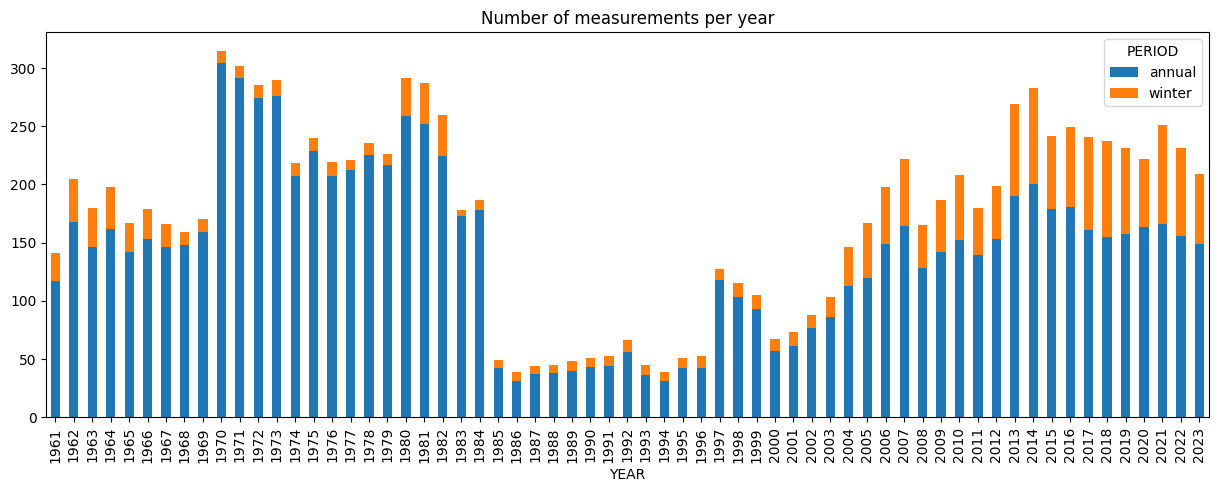

In [20]:
# Number of measurements per year:
df_pmb_topo60s.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, figsize=(15, 5))
plt.title('Number of measurements per year')

<Axes: xlabel='GLACIER'>

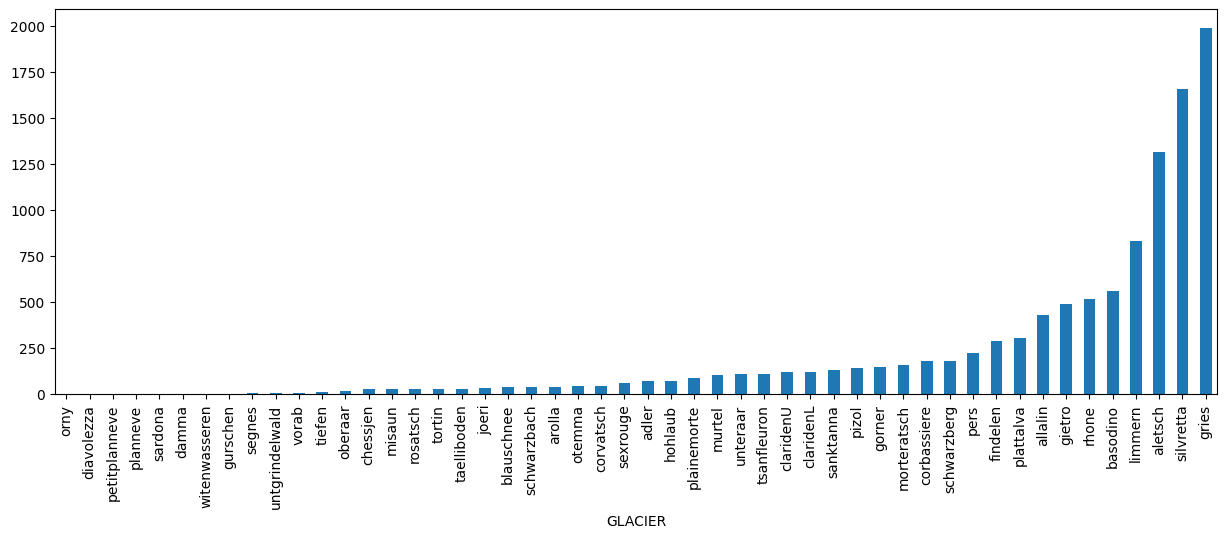

In [31]:
num_gl = df_pmb_topo60s.groupby(['GLACIER']).size().sort_values()
num_gl.plot(kind='bar', figsize=(15, 5))

In [41]:
big_gl

Index(['findelen', 'plattalva', 'allalin', 'gietro', 'rhone', 'basodino',
       'limmern', 'aletsch', 'silvretta', 'gries'],
      dtype='object', name='GLACIER')

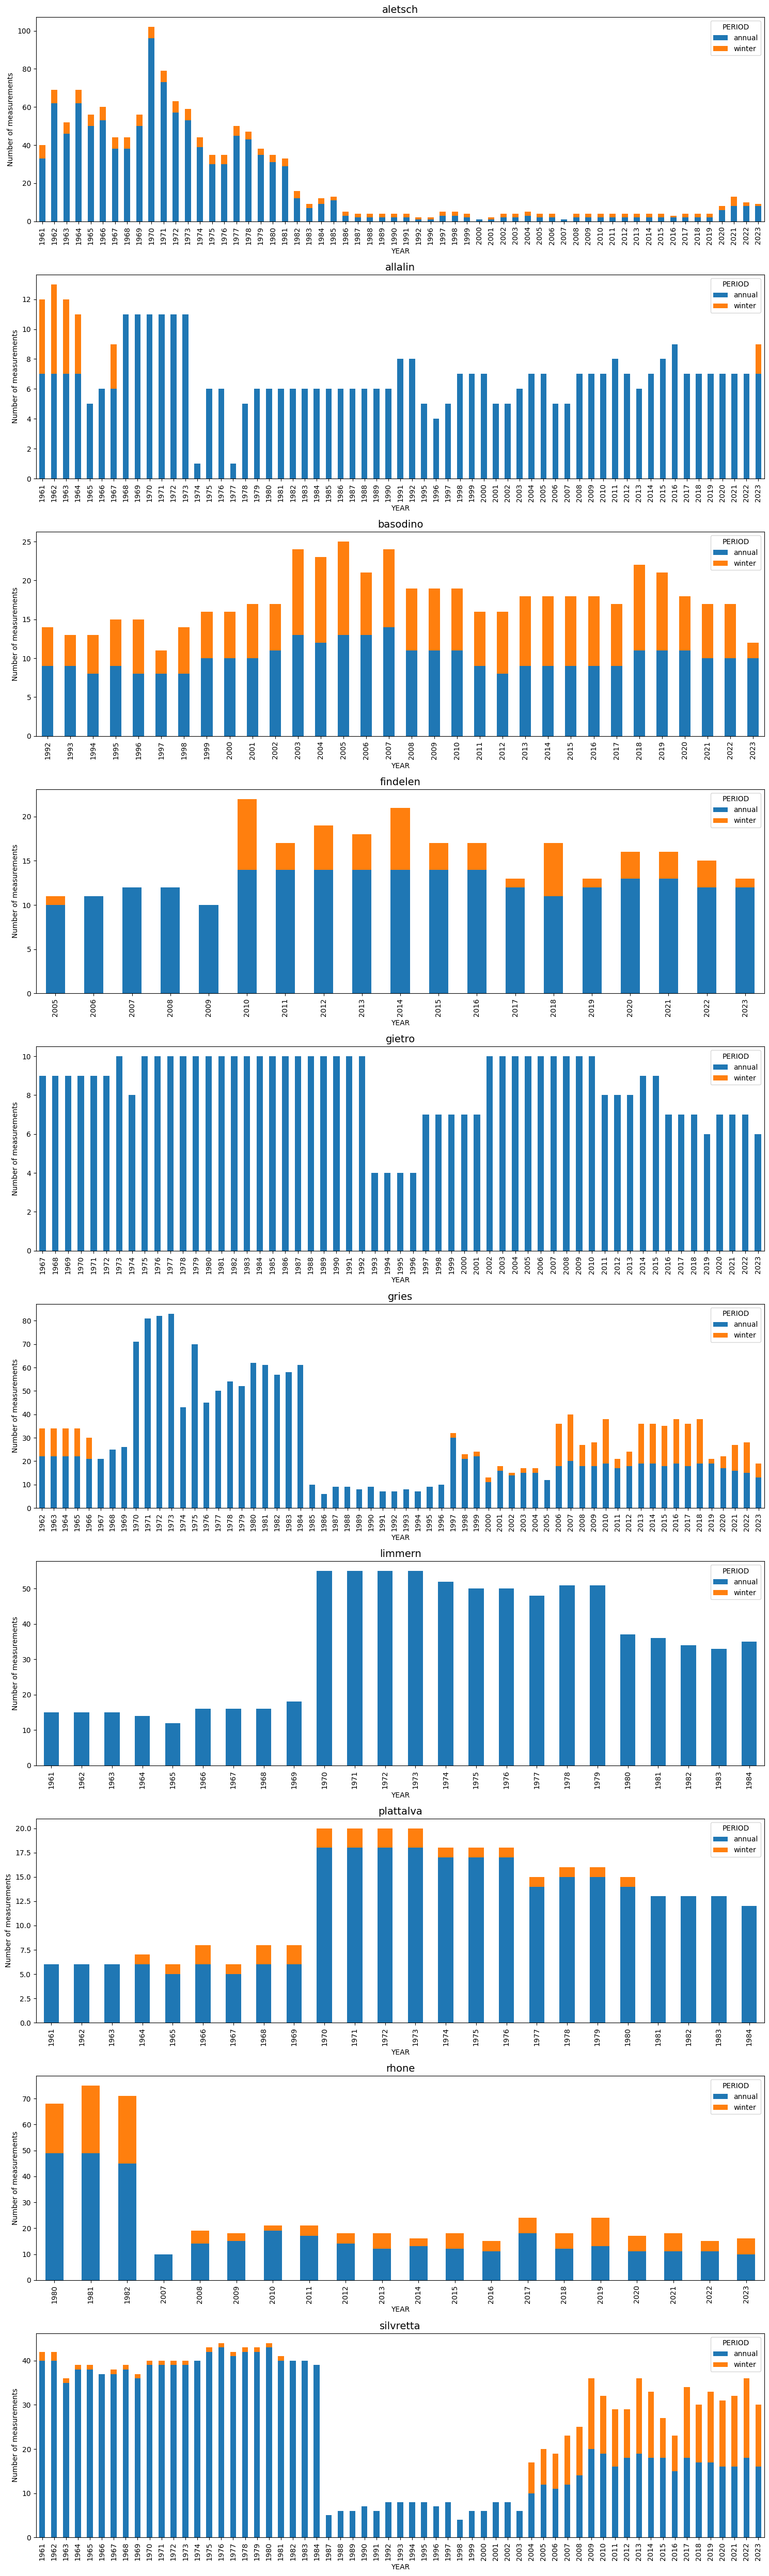

In [43]:
# Number of measurements per glacier per year:
num_gl_yr = df_pmb_topo60s.groupby(['GLACIER', 'YEAR', 'PERIOD']).size().unstack().reset_index()

# Plot one glacier per column:
big_gl = num_gl[num_gl > 250].index.sort_values()
num_glaciers = len(big_gl)
fig, ax = plt.subplots(num_glaciers, 1, figsize=(15, 5 * num_glaciers))
for i, gl in enumerate(big_gl):
    num_gl_yr[num_gl_yr.GLACIER == gl].plot(x='YEAR',
                                             kind='bar',
                                             stacked=True,
                                             ax=ax[i],
                                             title=gl)
    ax[i].set_ylabel('Number of measurements')
    ax[i].set_title(gl, fontsize = 14)
plt.tight_layout()

In [15]:
# historical stakes taken very closely at the same year:
# Get stakes per elevation bands:
N_bands = 10
df_aletsch = df_pmb_topo60s[df_pmb_topo60s.GLACIER == 'aletsch']
df_aletsch['EL_BIN'] = pd.cut(df_aletsch.POINT_ELEVATION,
                              N_bands,
                              precision=0,
                              labels=[f'EL_{i}' for i in range(N_bands)])

# # save aletsch coordinates
# df_aletsch[['GLACIER', 'POINT_ID', 'POINT_LAT', 'POINT_LON',
#               'PERIOD', 'YEAR', 'EL_BIN']].to_csv(path_PMB_GLAMOS_csv + 'coordinates_aletsch.csv')
df_aletsch

,YEAR,POINT_ID,GLACIER,FROM_DATE,TO_DATE,POINT_LAT,POINT_LON,POINT_ELEVATION,POINT_BALANCE,PERIOD,RGIId,aspect,slope,dis_from_border,topo,EL_BIN
3410,1961,EGIG,aletsch,1960-09-13,1961-09-08,46.546954,7.995952,3522.025096,-150,annual,RGI60-11.01450,NaN,NaN,NaN,NaN,EL_9
3411,1961,DD,aletsch,1960-09-09,1961-09-12,46.483956,8.058441,2651.321747,-2232,annual,RGI60-11.01450,NaN,NaN,NaN,NaN,EL_5
3412,1961,E,aletsch,1960-09-08,1961-09-12,46.492580,8.047916,2738.610461,-1656,annual,RGI60-11.01450,NaN,NaN,NaN,NaN,EL_5
3413,1961,EE,aletsch,1960-09-09,1961-09-12,46.482420,8.059666,2635.524393,-2439,annual,RGI60-11.01450,NaN,NaN,NaN,NaN,EL_5
3414,1961,F,aletsch,1960-09-08,1961-09-12,46.491004,8.049428,2728.912928,-2133,annual,RGI60-11.01450,NaN,NaN,NaN,NaN,EL_5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4529,2023,2122,aletsch,2022-09-21,2023-09-20,46.497910,8.041497,2685.103400,-4239,annual,RGI60-11.01450,NaN,NaN,NaN,NaN,EL_5
4530,2023,2222,aletsch,2022-09-21,2023-09-20,46.484925,8.057345,2568.120393,-5715,annual,RGI60-11.01450,NaN,NaN,NaN,NaN,EL_4
4531,2023,2422,aletsch,2022-09-21,2023-09-20,46.473159,8.070375,2462.137086,-5553,annual,RGI60-11.01450,NaN,NaN,NaN,NaN,EL_4
4532,2023,2722,aletsch,2022-09-21,2023-09-20,46.444878,8.079624,2299.198857,-7884,annual,RGI60-11.01450,NaN,NaN,NaN,NaN,EL_3


In [69]:
print(len(df_aletsch))
for year in tqdm(df_aletsch.YEAR.unique()):
    print(year)
    for period in ['annual', 'winter']:
        df_aletsch_y = df_aletsch[(df_aletsch.YEAR == year)
                                  & (df_aletsch.PERIOD == period)]

        # Calculate closest winter point to annual stake:
        df_aletsch_y['point'] = [(x, y) for x, y in zip(
            df_aletsch_y['POINT_LAT'], df_aletsch_y['POINT_LON'])]
        indices_to_drop = []
        for index, row in df_aletsch_y.iterrows():
            # find closest point except itself
            closest = closest_point(
                row.point,
                list(df_aletsch_y.drop(index=index, axis=0)['point']))
            index_closest = df_aletsch_y[df_aletsch_y['point'] ==
                                         closest].index

            # Convert to LAEA Europe
            x_laea, y_laea = latlon_to_laea(closest[0], closest[1])
            x_laea_point, y_laea_point = latlon_to_laea(
                row.point[0], row.point[1])

            # Calculate distance:
            distance_m = np.sqrt((x_laea_point - x_laea)**2 +
                                 (y_laea_point - y_laea)**2)
            if distance_m < 10:
                mean_MB = df_aletsch_y.loc[index_closest].POINT_BALANCE.mean()
                df_aletsch_y.loc[index_closest[0], 'POINT_BALANCE'] = mean_MB
                # drop other rows
                indices_to_drop.append(index_closest[1:])
        if len(indices_to_drop) > 0:
            df_aletsch_y.drop(index=np.concatenate(indices_to_drop),
                              inplace=True)
print(len(df_aletsch))


1315


  0%|          | 0/60 [00:00<?, ?it/s]

1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992


ValueError: XB must be a 2-dimensional array.

In [ ]:
# Plot number of measurements per decade or something:

#